In [5]:
# ============================================================================
# PART 1: INSTALLATION & SETUP
# ============================================================================


print("Installing packages...")
import subprocess, sys

subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "seaborn",
    "mlflow"
])
print("Installed\n")

Installing packages...
Installed



Identify NA data
perform imputation, using SimpleImputer to fix missing values
Apply StandardScaler and Enocding of Label and M/F, Yes /No to 1, 0 

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  
Saved PROCESSED dataset to: c:\Users\anshg\gitrepo\heart-mlops-azure\data\processed\heart_cleaned.csv


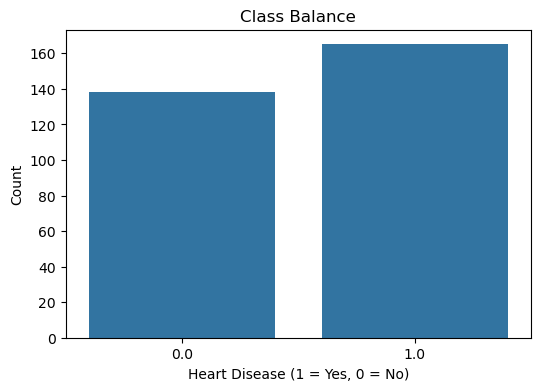

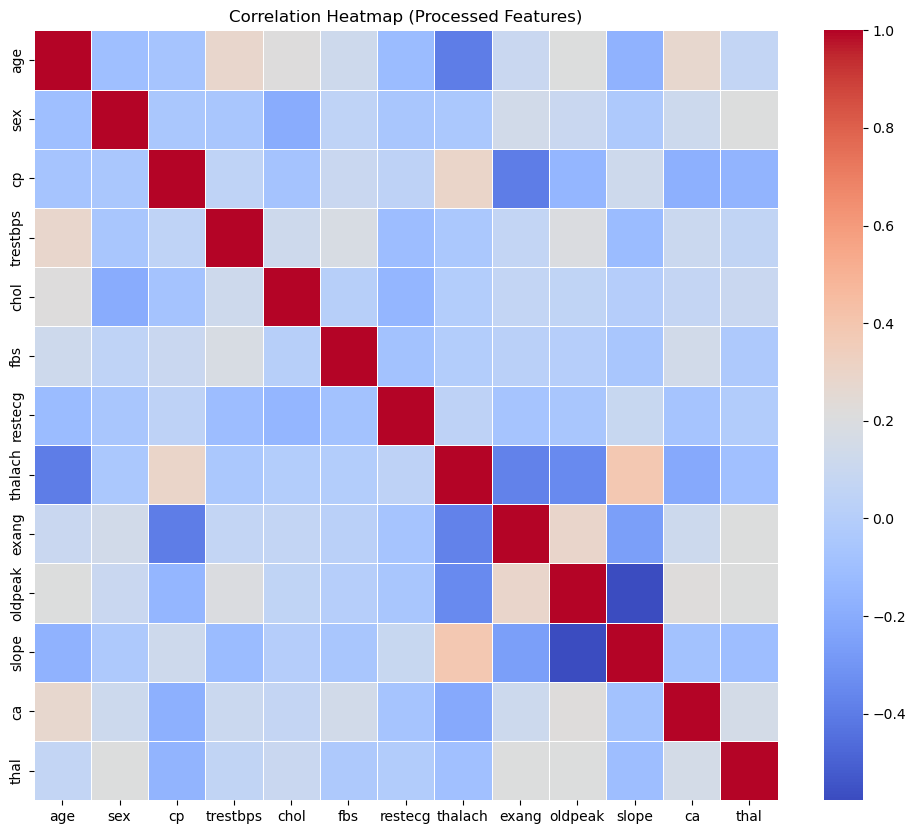

<Figure size 1200x1000 with 0 Axes>

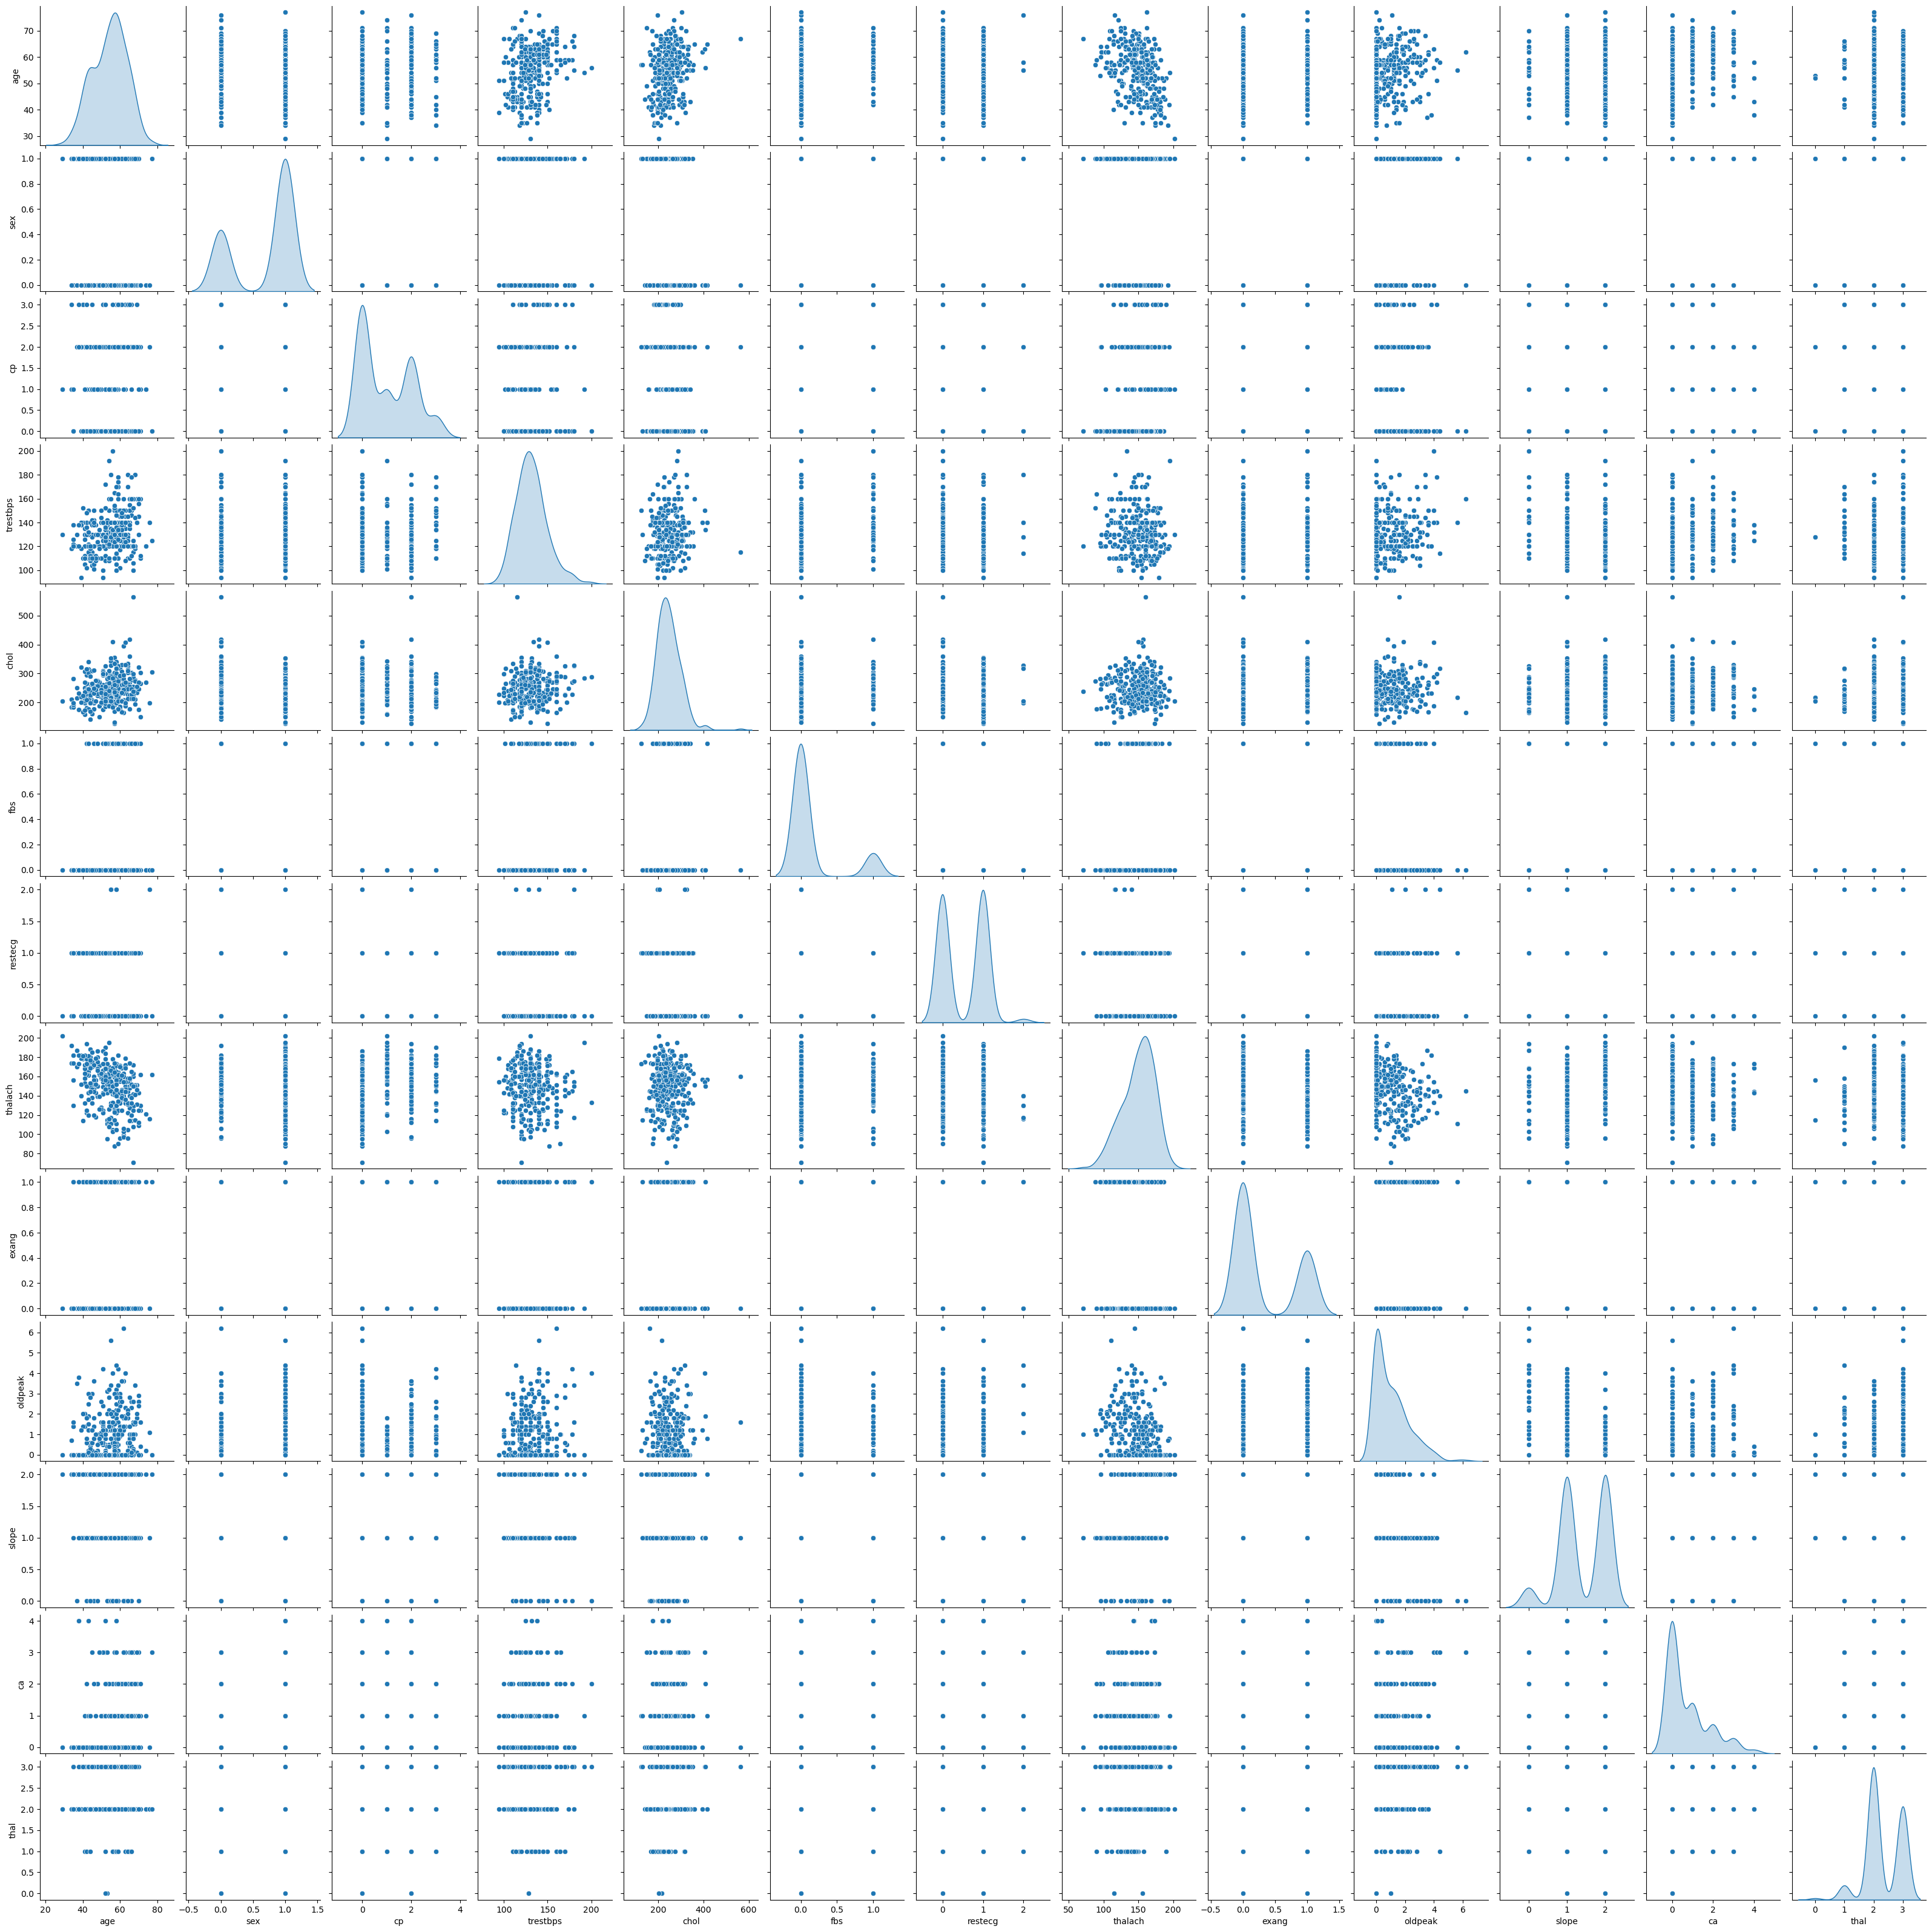

In [8]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from pathlib import Path


# Paths
base_dir = Path.cwd().parent
raw_path = base_dir / "data" / "raw" / "heart.csv"
processed_path = base_dir / "data" / "processed" / "heart_cleaned.csv"

# Load raw data
rawdf = pd.read_csv(raw_path)
print(rawdf.head())



def preprocess_data(df):
    """Clean NaNs, keep raw numeric/categorical values, no scaling, no encoding."""
    df = df.copy()

    # 1. Remove rows with missing values
    df = df.dropna()

    # 2. Identify feature types
    numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    # Remove target from feature lists
    if "target" in numeric_features:
        numeric_features.remove("target")
    if "target" in categorical_features:
        categorical_features.remove("target")

    # 3. Basic imputation only (NO SCALER, NO ENCODER)
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ],
        remainder="passthrough"   # keep everything else as-is
    )

    # 4. Apply transformations
    X = df.drop("target", axis=1)
    y = df["target"]

    X_processed = preprocessor.fit_transform(X)

    # Convert back to DataFrame
    X_processed_df = pd.DataFrame(X_processed, columns=numeric_features + categorical_features)

    processed_df = pd.concat([X_processed_df, y.reset_index(drop=True)], axis=1)

    return processed_df, numeric_features, categorical_features, X_processed_df


def save_processed_data(df):
    """Save cleaned & processed dataset."""
    output_path = processed_path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"Saved PROCESSED dataset to: {output_path}")


# Run preprocessing
df, num_cols, cat_cols, df_features = preprocess_data(rawdf)
save_processed_data(df)


# -----------------------------
# EDA SECTION (fixed)
# -----------------------------

# Class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x=df['target'])
plt.title("Class Balance")
plt.xlabel("Heart Disease (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Correlation heatmap (only numeric processed features)
plt.figure(figsize=(12, 10))
corr = df_features.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Processed Features)")
plt.show()

# Pairplot on RAW numeric features (correct)
plt.figure(figsize=(12, 10))
sns.pairplot(rawdf[num_cols], diag_kind="kde")
plt.show()

#### Training and Tracking

In [7]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [9]:
# Paths
base_dir = Path.cwd().parent
raw_path = base_dir / "data" / "raw" / "heart.csv"
processed_path = base_dir / "data" / "processed" / "heart_cleaned.csv"

df = pd.read_csv(processed_path)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


## Train/Test Split

In [10]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
def evaluate_and_plot(models, X_test, y_test):
    """
    Evaluate models and generate ROC, PR curves, and confusion matrix.
    """
    scores = {}

    for name, model in models.items():
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Compute metrics
        scores[name] = {
            "accuracy": accuracy_score(y_test, preds),
            "precision": precision_score(y_test, preds),
            "recall": recall_score(y_test, preds),
            "f1": f1_score(y_test, preds),
            "roc_auc": roc_auc_score(y_test, probs) if probs is not None else None
        }

        print(f"\n{name} metrics:")
        for metric, value in scores[name].items():
            print(f"  {metric}: {value}")

        # -------------------------
        # Plot ROC Curve
        # -------------------------
        if probs is not None:
            fpr, tpr, _ = roc_curve(y_test, probs)
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {scores[name]['roc_auc']:.2f}")
            plt.plot([0, 1], [0, 1], "k--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {name}")
            plt.legend(loc="lower right")
            roc_path = f"roc_curve_{name}.png"
            plt.savefig(roc_path)
            plt.close()
            mlflow.log_artifact(roc_path)

        # -------------------------
        # Plot Precision-Recall Curve
        # -------------------------
        if probs is not None:
            precision, recall, _ = precision_recall_curve(y_test, probs)
            plt.figure()
            plt.plot(recall, precision)
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve - {name}")
            pr_path = f"pr_curve_{name}.png"
            plt.savefig(pr_path)
            plt.close()
            mlflow.log_artifact(pr_path)

        # -------------------------
        # Plot Confusion Matrix
        # -------------------------
        disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)
        plt.title(f"Confusion Matrix - {name}")
        cm_path = f"confusion_matrix_{name}.png"
        plt.savefig(cm_path)
        plt.close()
        mlflow.log_artifact(cm_path)

    return scores

## Preprocessing Pipeline

In [12]:
numeric_features = X.select_dtypes(include=np.number).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)

## Train a Baseline Model (Logistic Regression)

In [13]:
logreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_pred = logreg_model.predict(X_test)
y_prob = logreg_model.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_prob)

print("Logical regression Accuracy:", lr_acc)
print("Logical regression AUC:", lr_auc)

Logical regression Accuracy: 0.8032786885245902
Logical regression AUC: 0.8690476190476191


## Random Forest Model

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

print("Random Forest Accuracy:", rf_acc)
print("Random Forest AUC:", rf_auc)

Random Forest Accuracy: 0.8360655737704918
Random Forest AUC: 0.9155844155844156


In [16]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [lr_acc, rf_acc],
    "AUC": [lr_auc, rf_auc]
})

results

,Model,Accuracy,AUC
0,Logistic Regression,0.803279,0.869048
1,Random Forest,0.836066,0.915584


In [21]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

mlflow.set_experiment("heart-disease-local")

# Prepare data for signature
X = df.drop("target", axis=1)
y = df["target"]

# -----------------------------
# Logistic Regression
# -----------------------------
signature_lr = infer_signature(X, logreg_model.predict(X))
input_example_lr = X.iloc[0].to_dict()

with mlflow.start_run(run_name="logreg"):
    mlflow.log_metric("accuracy", lr_acc)
    mlflow.log_metric("auc", lr_auc)
    mlflow.sklearn.log_model(
        logreg_model,
        name="logreg_model",
        signature=signature_lr,
        input_example=input_example_lr
    )

# -----------------------------
# Random Forest
# -----------------------------
signature_rf = infer_signature(X, rf_model.predict(X))
input_example_rf = X.iloc[0].to_dict()

with mlflow.start_run(run_name="random_forest"):
    mlflow.log_metric("accuracy", rf_acc)
    mlflow.log_metric("auc", rf_auc)
    mlflow.sklearn.log_model(
        rf_model,
        name="rf_model",
        signature=signature_rf,
        input_example=input_example_rf
    )